In [1]:
%%time
# Import Modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
pd.options.display.float_format = '{:,.2f}'.format
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score , confusion_matrix , precision_score , precision_recall_curve , f1_score
from sklearn.metrics import classification_report , roc_auc_score, recall_score
from sklearn.metrics import average_precision_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import sklearn.metrics as metrics
from joblib import dump, load
print("Numpy version: {}".format(np.__version__))
print("Pandas version: {}".format(pd.__version__))
#print("Sklearn version: {}".format(sklearn.__version__))
#print("Keras version: {}".format(keras.__version__))
#print("XBG Boost version: {}".format(xgboost.__version__))
import matplotlib as mpl
print ("Matplotlib version: {}".format(mpl.__version__))

Numpy version: 1.17.3
Pandas version: 0.25.2
Matplotlib version: 3.1.2
Wall time: 1.73 s


In [2]:
%%time
# Read csv file into dataframe
df = pd.read_csv('paysim.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
step              int64
type              object
amount            float64
nameOrig          object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest          object
oldbalanceDest    float64
newbalanceDest    float64
isFraud           int64
isFlaggedFraud    int64
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
Wall time: 10.6 s


In [3]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,"6,362,620.00","6,362,620.00","6,362,620.00","6,362,620.00","6,362,620.00","6,362,620.00","6,362,620.00","6,362,620.00"
mean,243.40,"179,861.90","833,883.10","855,113.67","1,100,701.67","1,224,996.40",0.00,0.00
std,142.33,"603,858.23","2,888,242.67","2,924,048.50","3,399,180.11","3,674,128.94",0.04,0.00
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,156.00,"13,389.57",0.00,0.00,0.00,0.00,0.00,0.00
50%,239.00,"74,871.94","14,208.00",0.00,"132,705.66","214,661.44",0.00,0.00
75%,335.00,"208,721.48","107,315.18","144,258.41","943,036.71","1,111,909.25",0.00,0.00
max,743.00,"92,445,516.64","59,585,040.37","49,585,040.37","356,015,889.35","356,179,278.92",1.00,1.00


In [4]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,"9,839.64",C1231006815,"170,136.00","160,296.36",M1979787155,0.00,0.00,0,0
1,1,PAYMENT,"1,864.28",C1666544295,"21,249.00","19,384.72",M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,"21,182.00",0.00,1,0
4,1,PAYMENT,"11,668.14",C2048537720,"41,554.00","29,885.86",M1230701703,0.00,0.00,0,0


In [5]:
%%time
# Convert "type" into categorical variables, e.g. values 0,1 for each type as its own column
df['type'] = df['type'].astype('category')
df = pd.get_dummies(df , columns= ['type'])
df.head()

Wall time: 1.83 s


,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,"9,839.64",C1231006815,"170,136.00","160,296.36",M1979787155,0.00,0.00,0,0,0,0,0,1,0
1,1,"1,864.28",C1666544295,"21,249.00","19,384.72",M2044282225,0.00,0.00,0,0,0,0,0,1,0
2,1,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,0,0,0,0,1
3,1,181.00,C840083671,181.00,0.00,C38997010,"21,182.00",0.00,1,0,0,1,0,0,0
4,1,"11,668.14",C2048537720,"41,554.00","29,885.86",M1230701703,0.00,0.00,0,0,0,0,0,1,0


In [6]:
# Define X with selected columns, y as the binary variable to predict
X = df.drop(['isFraud' , 'isFlaggedFraud' , 'nameOrig' , 'nameDest' ] , axis = 1 ).values
y = df['isFraud'].values

In [7]:
# Train, Test, Split to segregate Training from Test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [8]:
%%time
# Setup the pipeline
steps = [('scaler', StandardScaler()),
         ('rfc', RandomForestClassifier())
         ]

pipeline = Pipeline(steps)

# Create the hyperparameter grid
#c_space = np.logspace(-5, 8, 15)
param_grid = {'rfc__n_estimators': [10], 
              'rfc__max_depth': [None],
              'rfc__class_weight': [None],
              'rfc__criterion' : ['gini']}


# Instantiate the GridSearchCV object: logreg_cv
rfc = GridSearchCV(pipeline, param_grid, cv=5, verbose=True, n_jobs=-1)

# Fit it to the training data
rfc.fit(X_train, y_train)

rfc_predict = rfc.predict(X_test)

# Print the optimal parameters and best score
print("Tuned Logistic Regression Parameter: {}".format(rfc.best_params_))
print("Tuned Logistic Regression Accuracy: {}".format(rfc.best_score_))


# Compute and print metrics
print (confusion_matrix(y_test , rfc_predict))
print ("Accuracy score: ", accuracy_score(y_test , rfc_predict))
print("F1 score: ", f1_score(y_test , rfc_predict))
print("Precision score: " , precision_score(y_test , rfc_predict))
print("Recall score: " , recall_score(y_test , rfc_predict))
print("ROC-AUC score: " , roc_auc_score(y_test , rfc_predict))
print (classification_report(y_test , rfc_predict))
rfc


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.1min finished


Tuned Logistic Regression Parameter: {'rfc__class_weight': None, 'rfc__criterion': 'gini', 'rfc__max_depth': None, 'rfc__n_estimators': 10}
Tuned Logistic Regression Accuracy: 0.9996874602870246
[[1906301      50]
 [    522    1913]]
Accuracy score:  0.9997003330912947
F1 score:  0.8699408822191904
Precision score:  0.9745287824758023
Recall score:  0.7856262833675565
ROC-AUC score:  0.89280002762451
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.97      0.79      0.87      2435

    accuracy                           1.00   1908786
   macro avg       0.99      0.89      0.93   1908786
weighted avg       1.00      1.00      1.00   1908786

Wall time: 7min 23s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('rfc',
                                        RandomForestClassifier(bootstrap=True,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               min_impurity_decrease=0.0,
                  

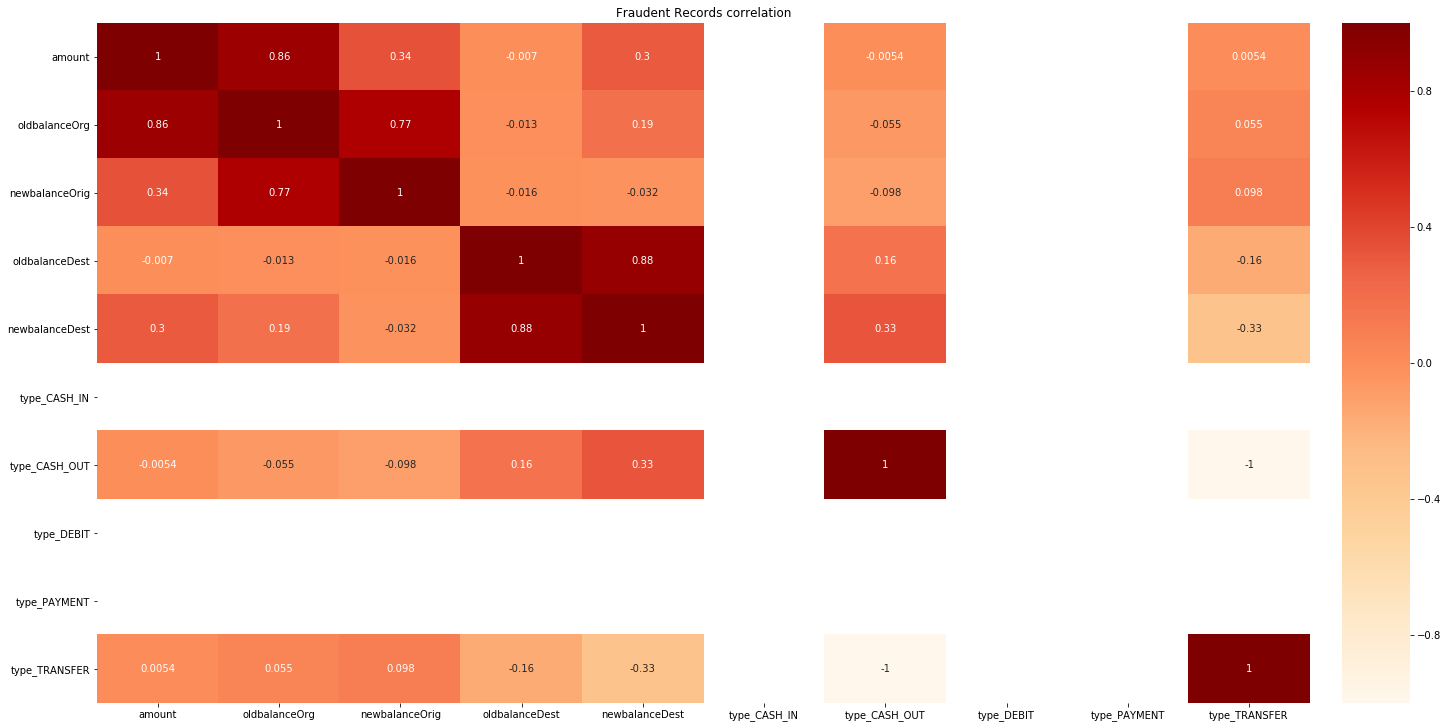

In [9]:
fig, ax = plt.subplots( 1,1, figsize=(20,10), constrained_layout=True)


ax.set_title("Fraudent Records correlation")
sns.heatmap(df.query('isFraud == 1').drop(['isFraud', 'isFlaggedFraud',  'step'],1).corr(),  cmap="OrRd", annot=True)
#sns.heatmap(df.query('isFraud == 1').drop(['isFraud', 'isFlaggedFraud'],1).corr(),  cmap="OrRd", ax=ax[0], annot=True)



In [10]:
#fig, ax = plt.subplots( 1,3, figsize=(20,5))

#ax[0].set_title("Fraudent Records correlation")
#sns.heatmap(df.query('isFraud == 1').drop(['isFraud', 'isFlaggedFraud',  'step'],1).corr(),  cmap="OrRd", ax=ax[0], annot=True)
#sns.heatmap(df.query('isFraud == 1').drop(['isFraud', 'isFlaggedFraud'],1).corr(),  cmap="OrRd", ax=ax[0], annot=True)

#ax[1].set_title("Non-fraudent Records correlation")
#sns.heatmap(df.drop(['isFraud', 'isFlaggedFraud'],1).corr(),  cmap="Purples", ax=ax[1], annot=True)
#sns.heatmap(df.query('isFraud == 0').drop(['isFraud', 'isFlaggedFraud', 'step'],1).corr(),  cmap="Purples", ax=ax[1], annot=True)
#sns.heatmap(df.query('isFraud == 0').drop(['isFraud', 'isFlaggedFraud'],1).corr(),  cmap="Purples", ax=ax[1], annot=True)

#ax[2].set_title("All Records correlation")
#sns.heatmap(df.drop(['isFraud', 'isFlaggedFraud', 'step'],1).corr(),  cmap="Greens", ax=ax[2], annot=True)
#sns.heatmap(df.drop(['isFraud', 'isFlaggedFraud', 'stepcount', 'timeofday', 'step'],1).corr(), annot=True, ax=ax[2])
#sns.heatmap(df.drop(['isFraud', 'isFlaggedFraud'],1).corr(), ax=ax[2], annot=True)
#plt.show()

In [11]:
df_cols = df[:0]
df_cols = df_cols.drop(['isFraud' , 'isFlaggedFraud' , 'nameOrig' , 'nameDest' ], axis = 1 )
for item1,item2 in sorted(zip(rfc.best_estimator_.named_steps['rfc'].feature_importances_,df_cols.columns),reverse=True):
    print(f'{item2} has a score of {item1}')

newbalanceDest has a score of 0.2947309956320353
oldbalanceOrg has a score of 0.2684622867851571
amount has a score of 0.13535972338117705
step has a score of 0.10795198308239398
oldbalanceDest has a score of 0.062126932496885945
type_TRANSFER has a score of 0.04997312883753983
type_CASH_OUT has a score of 0.04066835314773091
newbalanceOrig has a score of 0.037780315680861556
type_PAYMENT has a score of 0.0019591969155932916
type_CASH_IN has a score of 0.0009036406449302656
type_DEBIT has a score of 8.344339569479608e-05


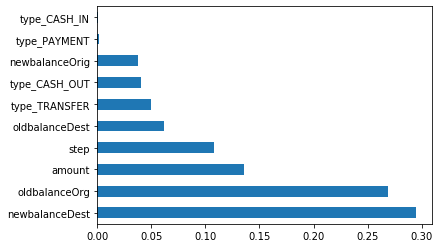

In [12]:
feat_importances = pd.Series(rfc.best_estimator_.named_steps['rfc'].feature_importances_, index=df_cols.columns)
#feat_importances.nlargest(4).plot(kind='barh')
#checking more than 4 because original omission of CASH_IN...should remove FlaggedFraud to see effect
feat_importances.nlargest(10).plot(kind='barh')

In [13]:
#create new columns for difference in Originator ID and Recipient ID
df.insert(2, 'ChangeOrig', (df['newbalanceOrig']-df['oldbalanceOrg']))
df.insert(3, 'ChangeDest', (df['newbalanceDest']-df['oldbalanceDest']))
df.describe()

,step,amount,ChangeOrig,ChangeDest,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
count,"6,362,620.00","6,362,620.00","6,362,620.00","6,362,620.00","6,362,620.00","6,362,620.00","6,362,620.00","6,362,620.00","6,362,620.00","6,362,620.00","6,362,620.00","6,362,620.00","6,362,620.00","6,362,620.00","6,362,620.00"
mean,243.40,"179,861.90","21,230.56","124,294.73","833,883.10","855,113.67","1,100,701.67","1,224,996.40",0.00,0.00,0.22,0.35,0.01,0.34,0.08
std,142.33,"603,858.23","146,643.29","812,939.08","2,888,242.67","2,924,048.50","3,399,180.11","3,674,128.94",0.04,0.00,0.41,0.48,0.08,0.47,0.28
min,1.00,0.00,"-10,000,000.00","-13,060,826.21",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,156.00,"13,389.57","-10,150.44",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,239.00,"74,871.94",0.00,0.00,"14,208.00",0.00,"132,705.66","214,661.44",0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,335.00,"208,721.48",0.00,"149,105.43","107,315.18","144,258.41","943,036.71","1,111,909.25",0.00,0.00,0.00,1.00,0.00,1.00,0.00
max,743.00,"92,445,516.64","1,915,267.90","105,687,838.82","59,585,040.37","49,585,040.37","356,015,889.35","356,179,278.92",1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [14]:
# Define X with selected columns, y as the binary variable to predict
X = df.drop(['isFraud' , 'isFlaggedFraud' , 'nameOrig' , 'nameDest' ] , axis = 1 ).values
y = df['isFraud'].values
# Train, Test, Split to segregate Training from Test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [15]:
%%time
# Setup the pipeline
steps = [('scaler', StandardScaler()),
         ('rfc', RandomForestClassifier())
         ]

pipeline = Pipeline(steps)

# Create the hyperparameter grid
#c_space = np.logspace(-5, 8, 15)
param_grid = {'rfc__n_estimators': [10], 
              'rfc__max_depth': [None],
              'rfc__class_weight': [None],
              'rfc__criterion' : ['gini']}


# Instantiate the GridSearchCV object: logreg_cv
rfc = GridSearchCV(pipeline, param_grid, cv=5, verbose=True, n_jobs=-1)

# Fit it to the training data
rfc.fit(X_train, y_train)

rfc_predict = rfc.predict(X_test)

# Print the optimal parameters and best score
print("Tuned Logistic Regression Parameter: {}".format(rfc.best_params_))
print("Tuned Logistic Regression Accuracy: {}".format(rfc.best_score_))


# Compute and print metrics
print (confusion_matrix(y_test , rfc_predict))
print ("Accuracy score: ", accuracy_score(y_test , rfc_predict))
print("F1 score: ", f1_score(y_test , rfc_predict))
print("Precision score: " , precision_score(y_test , rfc_predict))
print("Recall score: " , recall_score(y_test , rfc_predict))
print("ROC-AUC score: " , roc_auc_score(y_test , rfc_predict))
print (classification_report(y_test , rfc_predict))

rfc


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.5min finished


Tuned Logistic Regression Parameter: {'rfc__class_weight': None, 'rfc__criterion': 'gini', 'rfc__max_depth': None, 'rfc__n_estimators': 10}
Tuned Logistic Regression Accuracy: 0.999704524236871
[[1906300      51]
 [    500    1935]]
Accuracy score:  0.9997113348484324
F1 score:  0.8753675638995703
Precision score:  0.974320241691843
Recall score:  0.7946611909650924
ROC-AUC score:  0.8973172191420926
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.97      0.79      0.88      2435

    accuracy                           1.00   1908786
   macro avg       0.99      0.90      0.94   1908786
weighted avg       1.00      1.00      1.00   1908786

Wall time: 8min 23s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('rfc',
                                        RandomForestClassifier(bootstrap=True,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               min_impurity_decrease=0.0,
                  

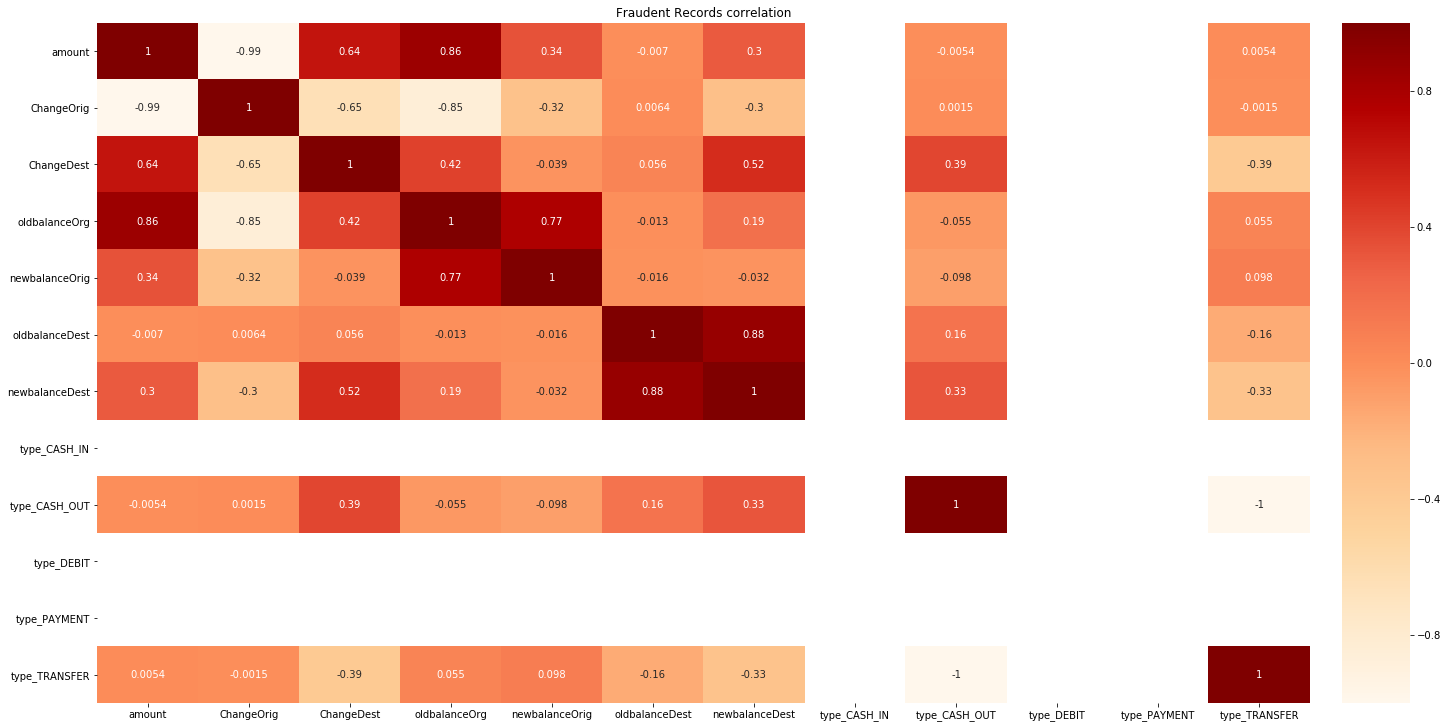

In [16]:
fig, ax = plt.subplots( 1,1, figsize=(20,10), constrained_layout=True)

ax.set_title("Fraudent Records correlation")
sns.heatmap(df.query('isFraud == 1').drop(['isFraud', 'isFlaggedFraud',  'step'],1).corr(),  cmap="OrRd", annot=True)
#sns.heatmap(df.query('isFraud == 1').drop(['isFraud', 'isFlaggedFraud'],1).corr(),  cmap="OrRd", ax=ax[0], annot=True)



In [17]:
df_cols = df[:0]
df_cols = df_cols.drop(['isFraud' , 'isFlaggedFraud' , 'nameOrig' , 'nameDest' ], axis = 1 )
for item1,item2 in sorted(zip(rfc.best_estimator_.named_steps['rfc'].feature_importances_,df_cols.columns),reverse=True):
    print(f'{item2} has a score of {item1}')

ChangeOrig has a score of 0.2591119886975115
ChangeDest has a score of 0.20264572655180563
oldbalanceOrg has a score of 0.1269775992935051
newbalanceDest has a score of 0.10918576736547511
amount has a score of 0.10259802774734494
step has a score of 0.07783498609374111
oldbalanceDest has a score of 0.06183958223674
newbalanceOrig has a score of 0.02554891775407651
type_TRANSFER has a score of 0.022453960860449297
type_CASH_OUT has a score of 0.00934941011387008
type_CASH_IN has a score of 0.0015863921530974803
type_PAYMENT has a score of 0.0008153926537088024
type_DEBIT has a score of 5.224847867441199e-05


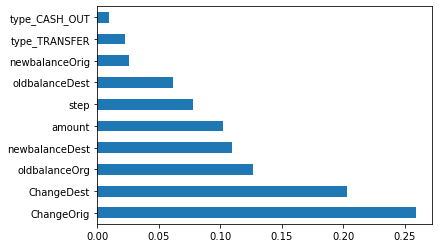

In [18]:
feat_importances = pd.Series(rfc.best_estimator_.named_steps['rfc'].feature_importances_, index=df_cols.columns)
#feat_importances.nlargest(4).plot(kind='barh')
#checking more than 4 because original omission of CASH_IN...should remove FlaggedFraud to see effect
feat_importances.nlargest(10).plot(kind='barh')

In [19]:
%%time
pd.to_datetime(df['step'][0])

Wall time: 244 ms


Timestamp('1970-01-01 00:00:00.000000001')

In [20]:
%%time
df['steptime'] = df['step'].apply(lambda x: pd.to_datetime(x, unit='h'))

Wall time: 28min 28s


In [21]:
%%time
df['dayofweek'] = df['steptime'].dt.weekday
#df['dayofweek'] = pd.Categorical(df['steptime'].dt.weekday_name,
#                                       ordered=True,
#                                       categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

Wall time: 546 ms
Parser   : 105 ms


In [22]:
%%time
df['timeofday'] = df['steptime'].dt.hour + df['steptime'].dt.minute / 60

Wall time: 2.89 s


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 20 columns):
step              int64
amount            float64
ChangeOrig        float64
ChangeDest        float64
nameOrig          object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest          object
oldbalanceDest    float64
newbalanceDest    float64
isFraud           int64
isFlaggedFraud    int64
type_CASH_IN      uint8
type_CASH_OUT     uint8
type_DEBIT        uint8
type_PAYMENT      uint8
type_TRANSFER     uint8
steptime          datetime64[ns]
dayofweek         int64
timeofday         float64
dtypes: datetime64[ns](1), float64(8), int64(4), object(2), uint8(5)
memory usage: 758.5+ MB


In [24]:
# Define X with selected columns, y as the binary variable to predict
X = df.drop(['isFraud' , 'isFlaggedFraud' , 'nameOrig' , 'nameDest', 'steptime' ] , axis = 1 ).values
y = df['isFraud'].values
# Train, Test, Split to segregate Training from Test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [25]:
%%time
# Setup the pipeline
steps = [('scaler', StandardScaler()),
         ('rfc', RandomForestClassifier())
         ]

pipeline = Pipeline(steps)

# Create the hyperparameter grid
#c_space = np.logspace(-5, 8, 15)
param_grid = {'rfc__n_estimators': [10], 
              'rfc__max_depth': [None],
              'rfc__class_weight': [None],
              'rfc__criterion' : ['gini']}


# Instantiate the GridSearchCV object: logreg_cv
rfc = GridSearchCV(pipeline, param_grid, cv=5, verbose=True, n_jobs=-1)

# Fit it to the training data
rfc.fit(X_train, y_train)

rfc_predict = rfc.predict(X_test)

# Print the optimal parameters and best score
print("Tuned Logistic Regression Parameter: {}".format(rfc.best_params_))
print("Tuned Logistic Regression Accuracy: {}".format(rfc.best_score_))


# Compute and print metrics
print (confusion_matrix(y_test , rfc_predict))
print ("Accuracy score: ", accuracy_score(y_test , rfc_predict))
print("F1 score: ", f1_score(y_test , rfc_predict))
print("Precision score: " , precision_score(y_test , rfc_predict))
print("Recall score: " , recall_score(y_test , rfc_predict))
print("ROC-AUC score: " , roc_auc_score(y_test , rfc_predict))
print (classification_report(y_test , rfc_predict))
rfc


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.8min finished


Tuned Logistic Regression Parameter: {'rfc__class_weight': None, 'rfc__criterion': 'gini', 'rfc__max_depth': None, 'rfc__n_estimators': 10}
Tuned Logistic Regression Accuracy: 0.9997442652779606
[[1906322      29]
 [    441    1994]]
Accuracy score:  0.9997537701973925
F1 score:  0.8945715567519067
Precision score:  0.9856648541769649
Recall score:  0.8188911704312115
ROC-AUC score:  0.9094379790612303
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.99      0.82      0.89      2435

    accuracy                           1.00   1908786
   macro avg       0.99      0.91      0.95   1908786
weighted avg       1.00      1.00      1.00   1908786

Wall time: 7min 30s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('rfc',
                                        RandomForestClassifier(bootstrap=True,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               min_impurity_decrease=0.0,
                  

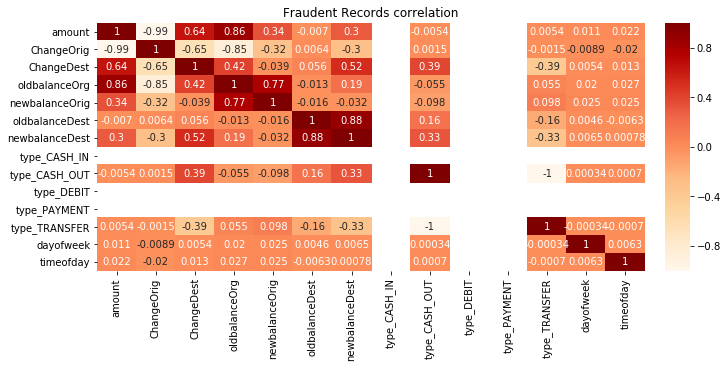

In [26]:
fig, ax = plt.subplots( 1,1, figsize=(10,5), constrained_layout=True)

ax.set_title("Fraudent Records correlation")
sns.heatmap(df.query('isFraud == 1').drop(['isFraud', 'isFlaggedFraud',  'step'],1).corr(),  cmap="OrRd", annot=True)
#sns.heatmap(df.query('isFraud == 1').drop(['isFraud', 'isFlaggedFraud'],1).corr(),  cmap="OrRd", ax=ax[0], annot=True)


In [27]:
df_cols = df[:0]
df_cols = df_cols.drop(['isFraud' , 'isFlaggedFraud' , 'nameOrig' , 'nameDest', 'steptime' ], axis = 1 )
for item1,item2 in sorted(zip(rfc.best_estimator_.named_steps['rfc'].feature_importances_,df_cols.columns),reverse=True):
    print(f'{item2} has a score of {item1}')

ChangeOrig has a score of 0.2966040459871787
ChangeDest has a score of 0.16823410697481936
newbalanceDest has a score of 0.09565318523494132
step has a score of 0.0809424114265153
amount has a score of 0.08000583051310302
oldbalanceOrg has a score of 0.07464266274974793
oldbalanceDest has a score of 0.0497702899065288
timeofday has a score of 0.04320794072319619
type_TRANSFER has a score of 0.03442193259079697
newbalanceOrig has a score of 0.03109757528411573
type_CASH_OUT has a score of 0.028844836192289707
dayofweek has a score of 0.012056982423121646
type_PAYMENT has a score of 0.00399874433385127
type_DEBIT has a score of 0.0003588387333399342
type_CASH_IN has a score of 0.00016061692645405885


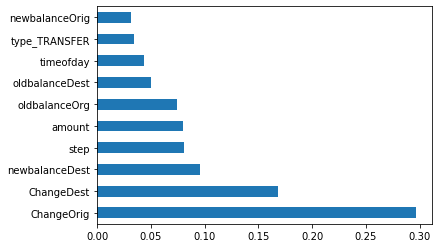

In [28]:
feat_importances = pd.Series(rfc.best_estimator_.named_steps['rfc'].feature_importances_, index=df_cols.columns)
#feat_importances.nlargest(4).plot(kind='barh')
#checking more than 4 because original omission of CASH_IN...should remove FlaggedFraud to see effect
feat_importances.nlargest(10).plot(kind='barh')